# Coding up SWAN equations
Just getting the matrices right but treating this like explicit scheme instead of implicit.
Based on [SWAN documentation](https://swanmodel.sourceforge.io/online_doc/swantech/swantech.html).

## 1D Wave evolution in $x$-direction
$$\frac{\partial N}{\partial t} + \frac{\partial_{c_x} N}{\partial x} = S_\text{tot} \qquad (3.1) $$
is discretized (assuming $c_x > 0$) to 
$$ \left(\frac{N^n - N^{n-1}}{\Delta t}\right)_{i,j,l,m} = \left(\frac{(c_x N)_i - (c_x N)_{i-1}}{\Delta x}\right)^n_{j,l,m} + S_\text{tot, (i,j,l,m)}^n \qquad (3.5) $$

CFL is 0.20, this should be less than 1/2.


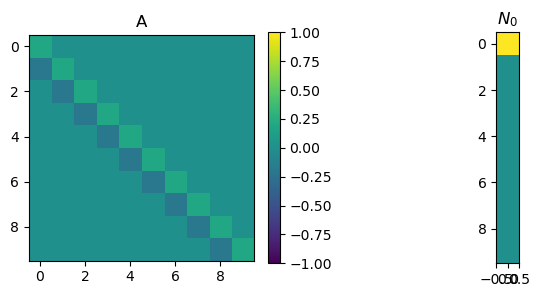

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import swan
from importlib import reload

nx = 10
dt = 1
dx = 1
cx = 0.2
print(f"CFL is {cx * dt / dx:.2f}, this should be less than 1/2.")

N = np.zeros([nx,1]) # initital conditions column vector
N[0] = 1

# source term for later
Sin = np.zeros([nx,1])
Sin[0, 0] = 1

#A = np.diag((cx / (dx)) * np.ones(nx)) - np.diag((cx / (dx)) * np.ones(nx - 1), -1)
A = swan.bsbt_matrix(1, 0, cx * np.ones(nx), np.array([0]), 1, 1)

vmin = -1
vmax = 1
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(A, vmin=vmin, vmax=vmax)
ax[0].set_title(r'A')
ax[1].imshow(N, vmin=vmin, vmax=vmax)
ax[1].set_title(r'$N_0$')

plt.colorbar(im);

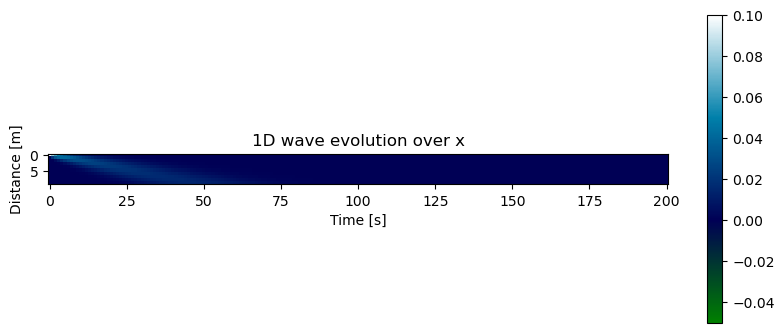

In [79]:
T = 200

N = np.zeros([nx, 1]) # initital conditions column vector
N[0] = 0.1

N_mat = np.zeros([nx, T + 1])
N_mat[:, 0] = N[:,0]
total_flux = []

Sin_func = lambda t: Sin * 0.5 * (1 + np.sin(2 * np.pi * t / 50))

for t in range(T):
    total_flux.append(cx * N.sum())
    N = N - dt * (A @ N) #- dt * Sin_func(t)
    N_mat[:, t + 1] = N.squeeze()
    
fig, axs = plt.subplots(figsize=(nx, 4))
im = axs.imshow(N_mat, cmap="ocean", vmin=-.05)
plt.colorbar(im)
axs.set_xlabel('Time [s]');
axs.set_ylabel('Distance [m]')
axs.set_title('1D wave evolution over x');

Action flux (cgN) is conserved in 1D propagation.


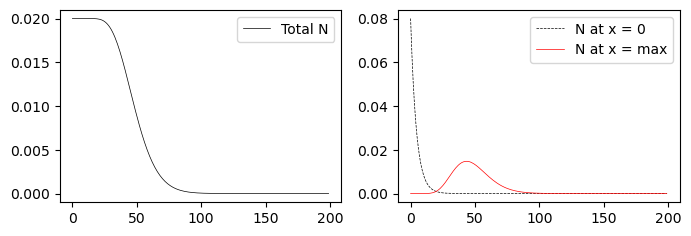

In [80]:
# this is a test now
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
ax = axs[0]
ax.plot(range(T), total_flux, linewidth=.5, color='k', label='Total N')
ax.legend();
ax = axs[1]
ax.plot(range(T), N_mat[0, 1:], linewidth=.5, color='k', linestyle='dashed', label='N at x = 0')
ax.plot(range(T), N_mat[-1, 1:], linewidth=.5, color='red', label='N at x = max')
ax.legend();

assert np.isclose(N_mat[-1, :].sum(), N_mat[0, :].sum())
print(r"Action flux (cgN) is conserved in 1D propagation.")

## 2D wave evolution in $(x,y)$-direction

$$\frac{\partial N}{\partial t} + \frac{\partial_{c_x} N}{\partial x} + \frac{\partial_{c_y} N}{\partial y} = S_\text{tot} \qquad (3.1) $$

In [4]:
# construct update matrix with new values
def bsbt_matrix(nx, ny, cx, cy, dx, dy):
    A = np.diag((cx.ravel() / dx) + (cy.ravel() / dy))
    A -= np.diag((cx.ravel()[ny:] / dx), -ny)
    A -= np.diag((cy.ravel()[1:] / dy), -1)
    return A

def sordup_matrix(nx, ny, cx, cy, dx, dy):
    A = np.diag(3 * (cx.ravel() / (2 * dx)) + 3 * (cy.ravel() / (2 * dy)))
    # x updates
    A -= np.diag(4 * (cx.ravel()[1:] / (2 * dx)), -1)
    A += np.diag((cx.ravel()[2:] / (2 * dx)), -2)
    # y updates
    A -= np.diag(4 * (cy.ravel()[nx:] / (2 * dy)), -nx)
    A += np.diag((cy.ravel()[2 * nx:] / (2 * dy)), -2 * nx)
    return A

CFLx: 0.00
CFLy: 0.31


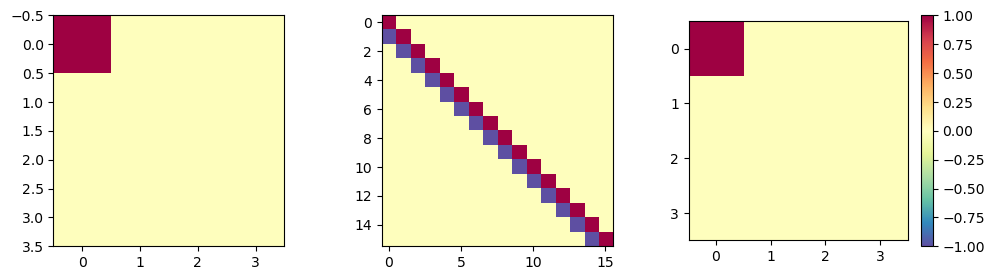

In [50]:
# defaults
nx = 4
ny = 4
dx = 1
dy = 1
dt = 0.1
θ = np.pi / 2
u = np.array([0, 0])
k = swan.κ

# depth h
h = np.ones([ny, nx]) 

# relative frequency by depth
sigma = swan.relative_frequency(k, h)

# group velocity with depth
cg = swan.group_velocity(k, h, sigma)
cx, cy = swan.spatial_group_velocity(cg, θ)

print("CFLx: {:.2f}".format(dt * np.max(cx) / dx))
print("CFLy: {:.2f}".format(dt * np.max(cy) / dy))


N = np.zeros([ny, nx])
N[0, 0] = 1
vmin = -1
vmax = 1

A = bsbt_matrix(nx, ny, cx, cy, dx, dy)

# source term for later
Sin = np.zeros([ny, nx])
Sin[0, 0] = 10

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(N, vmin=vmin, vmax=vmax, cmap='Spectral_r')
axs[1].imshow(A, vmin=vmin, vmax=vmax, cmap='Spectral_r')
im = axs[2].imshow(Sin, vmin=vmin, vmax=vmax, cmap='Spectral_r')
plt.colorbar(im);

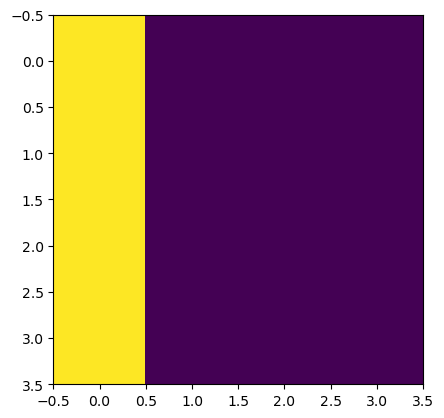

In [51]:
xmin, xmax, ymin, ymax = swan.indicate_boundaries2d(ny, nx)
plt.imshow(xmin.reshape([ny, nx], order=swan.order));

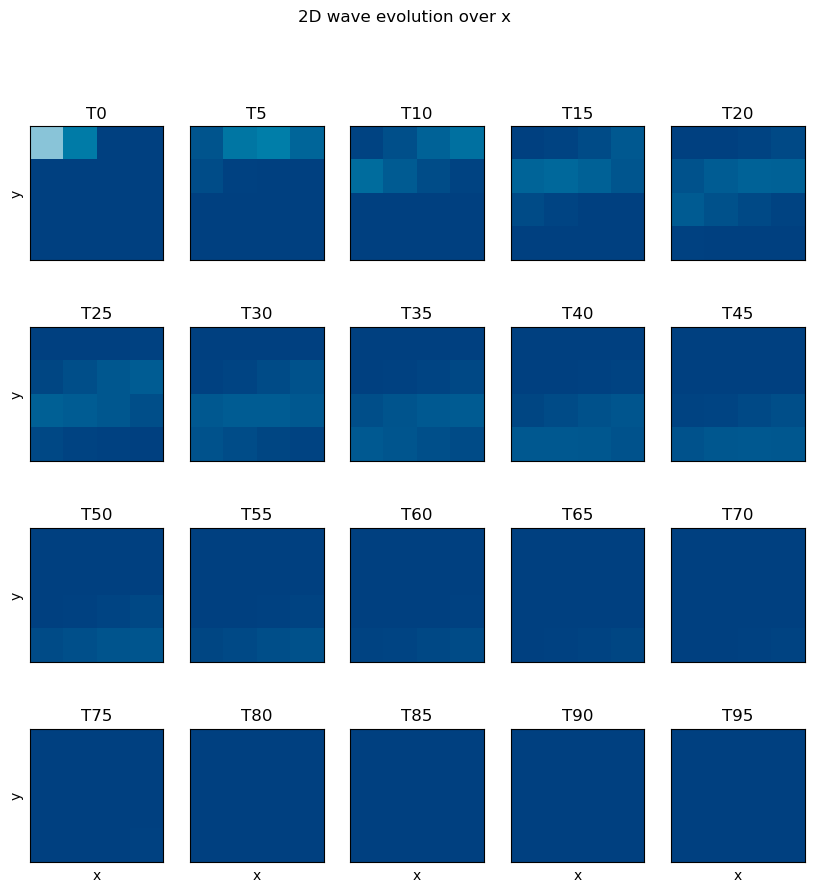

In [52]:
N1 = N.ravel(order=swan.order)[:, np.newaxis]
Sin = Sin.ravel(order=swan.order)[:, np.newaxis]
Sin_func = lambda t: Sin * 0.5 * (1 + np.sin(2 * np.pi * t / (2 * swan.λ)))

# initial boundary fluxes
x_influx = []# [N1[xmin].sum()]
x_outflux = []# [N1[xmax].sum()]
y_influx = []# [N1[ymin].sum()]
y_outflux = []# [N1[ymax].sum()]

T = 100
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
i = 0
for t in range(T):
    N1 = N1 - dt * (A @ N1) #- dt * Sin_func(t)
    
    # check boundary fluxes
    x_influx.append(N1[xmin].sum())
    x_outflux.append(N1[xmax].sum())
    y_influx.append(N1[ymin].sum())
    y_outflux.append(N1[ymax].sum())

    if t % int(T / 20) == 0 :
        ax = axs.ravel()[i]
        ax.imshow(N1.reshape(ny,nx), vmin=vmin, vmax=vmax, cmap='ocean')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('x');
        ax.set_ylabel('y');
        ax.set_title(f"T{t}");
        ax.label_outer();
        i += 1

plt.suptitle('2D wave evolution over x');

In [42]:
sum(x_influx), sum(y_influx), sum(y_outflux), sum(x_outflux)

(3.2460876270441568, 4.321431433632812, 2.5200778860703568, 3.65554695690913)

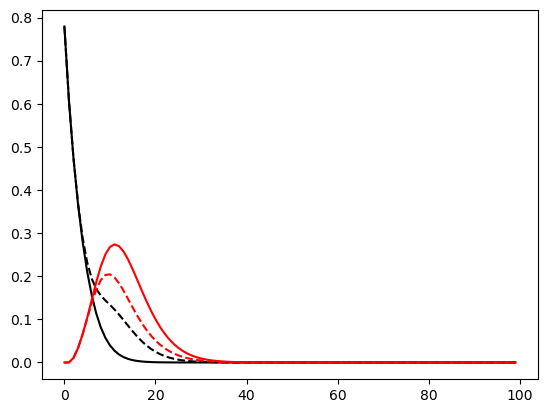

In [36]:
fig, ax = plt.subplots()

ax.plot(range(T), x_influx, color='k')
ax.plot(range(T), y_influx, color='k', linestyle='dashed')
ax.plot(range(T), x_outflux, color='red')
ax.plot(range(T), y_outflux, color='red', linestyle='dashed');

## Simple varying bathymetry

CFLx: 0.12
CFLy: 0.10


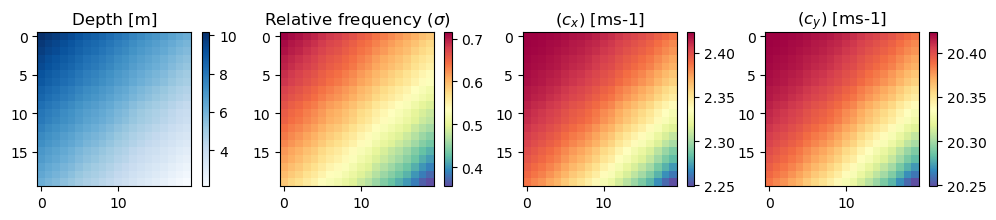

In [15]:
from variables import *

nx = 20
ny = 20
dx = 2
dy = 20
dt = 0.1
u = np.array([1, 10])

# depth h
hx = (np.linspace(5, 1, nx) + 0.1 * np.random.random(nx))[np.newaxis, :]
hy = (np.linspace(5, 1, ny) + 0.1 * np.random.random(ny))[:, np.newaxis]
h = np.repeat(hy, nx, axis=1) + np.repeat(hx, ny, axis=0)

# relative frequency by depth
sigma = relative_frequency(k, h)

# group velocity with depth
cg = group_velocity(k, h, sigma, u)
cx, cy = spatial_velocity(cg, u)

print("CFLx: {:.2f}".format(dt * np.max(cx) / dx))
print("CFLy: {:.2f}".format(dt * np.max(cy) / dy))

# visualise
fig, axs = plt.subplots(1, 4, figsize=(12, 2))
ax = axs[0]
im = ax.imshow(h, cmap='Blues')
plt.colorbar(im)
ax.set_title('Depth [m]');

ax = axs[1]
im = ax.imshow(sigma, cmap='Spectral_r')
plt.colorbar(im)
ax.set_title(r'Relative frequency ($\sigma$)');

ax = axs[2]
im = ax.imshow(cx, cmap='Spectral_r')
plt.colorbar(im)
ax.set_title(r'($c_x$) [ms-1]');

ax = axs[3]
im = ax.imshow(cy, cmap='Spectral_r')
plt.colorbar(im)
ax.set_title(r'($c_y$) [ms-1]');

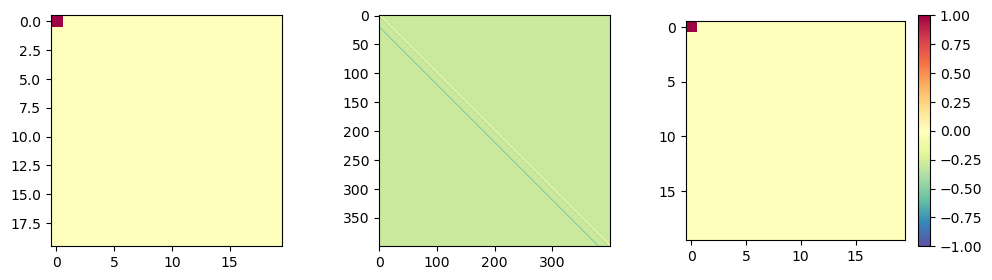

In [16]:
N = np.zeros([ny, nx])
N[0, 0] = 1
vmin = -1
vmax = 1

A = bsbt_matrix(nx, ny, cx, cy, dx, dy)

# source term for later
Sin = np.zeros([ny, nx])
Sin[0, 0] = 10

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(N, vmin=vmin, vmax=vmax, cmap='Spectral_r')
axs[1].imshow(A, cmap='Spectral_r')
im = axs[2].imshow(Sin, vmin=vmin, vmax=vmax, cmap='Spectral_r')
plt.colorbar(im);

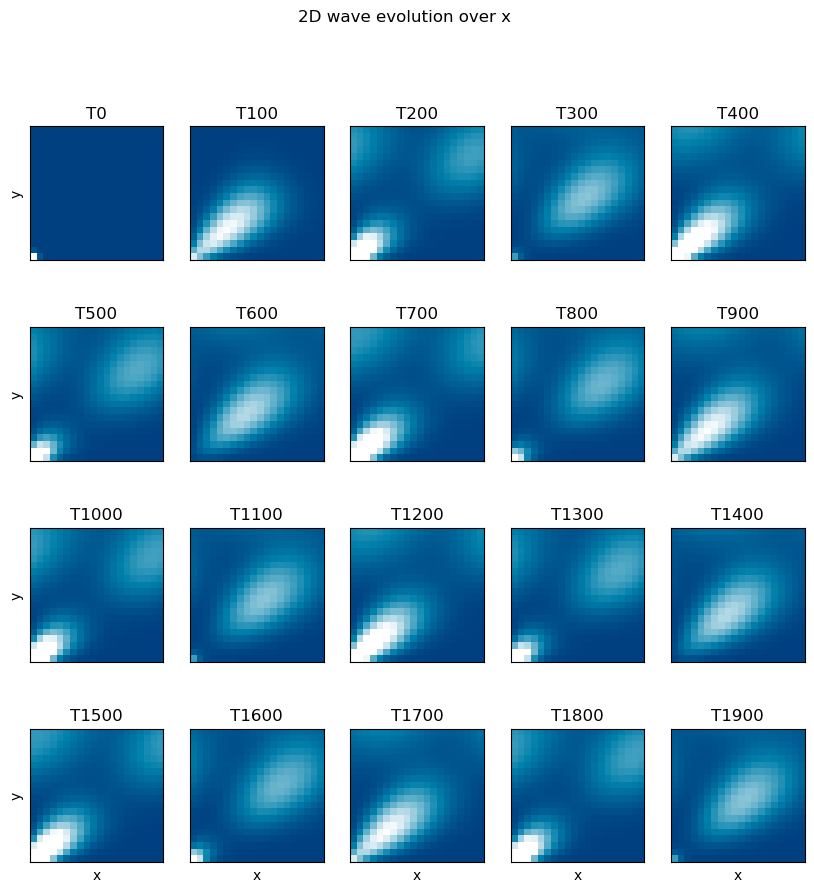

In [17]:
N1 = N.ravel()[:, np.newaxis]
Sin = Sin.ravel()[:, np.newaxis]
Sin_func = lambda t: Sin * 0.5 * (1 + np.sin(2 * np.pi * t / (2 * λ)))

T = 2000

fig, axs = plt.subplots(4, 5, figsize=(10, 10))
i = 0
for t in range(T):
    N1 -=  dt * (A @ N1) - dt * Sin_func(t)
    if t % 100 == 0 :
        ax = axs.ravel()[i]
        ax.imshow(N1.reshape(ny,nx), vmin=vmin, vmax=vmax, cmap='ocean')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('x');
        ax.set_ylabel('y');
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_title(f"T{t}");
        ax.label_outer();
        i += 1

plt.suptitle('2D wave evolution over x');

## Four directions prep

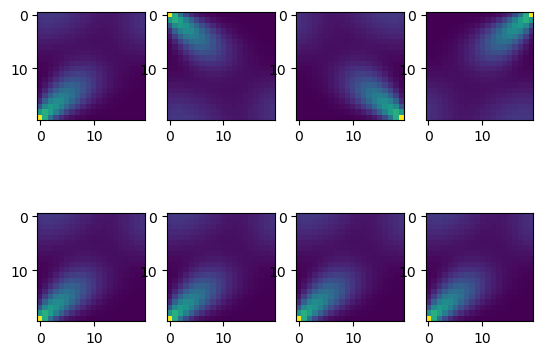

In [23]:
# reordering grid points for the four sweeps
N = N1.reshape([nx, ny])
N1 = N[:, ::-1]
N2 = N[::-1, :]
N3 = N[::-1, ::-1]

fig, axs = plt.subplots(2, 4)

axs[0, 0].imshow(N)
axs[0, 1].imshow(N1)
axs[0, 2].imshow(N2)
axs[0, 3].imshow(N3)

N = N.ravel()
N1 = N1.ravel()
N2 = N2.ravel()
N3 = N3.ravel()

N = N.reshape([nx, ny])
N1 = N1.reshape([nx, ny])[::-1, :]
N2 = N2.reshape([nx, ny])[:, ::-1]
N3 = N3.reshape([nx, ny])[::-1, ::-1]

axs[1, 0].imshow(N)
axs[1, 1].imshow(N1)
axs[1, 2].imshow(N2)
axs[1, 3].imshow(N3)

# Spectral solution for single grid cell

In [364]:
def group_velocity(k, d, σ, u):
    """cg = (1 / 2) * (1 + (2 * l2(k) * d) / np.sinh(2 * l2(k) * d)) * (σ * k) / l2(k)**2 + u"""
    σ = np.array(σ)
    cg = (1 / 2) * (1 + (2 * l2(k) * d) / np.sinh(2 * l2(k) * d))
    cg = cg[..., np.newaxis] * np.einsum('n,md->mnd',σ,k) / l2(k)
    cg = cg + u
    return cg


def hybrid_matrix_theta(cθ, step, nu=0.5):
    """nu=0: upwind scheme, nu=1: central difference scheme.
    step should be 1 for row-major ('C') ordering in (σ,θ).
    """
    cθ = cθ.ravel(order='C').copy() # numpy arrays are mutable
    counter_clockwise = cθ >= 0
    
    coeff_diag = np.where(counter_clockwise, 1 - 0.5 * nu, 0.5 * nu)
    coeff_super = np.where(counter_clockwise, 0.5 * nu, 1 - 0.5 * nu)
    left = coeff_diag * np.diag(cθ)
    left += coeff_super * np.diag(cθ[:-step], step)
    
    coeff_diag = np.where(counter_clockwise, 0.5 * nu, 1 - 0.5 * nu)
    coeff_sub = np.where(counter_clockwise, 1 - 0.5 * nu, 0.5 * nu)
    right = coeff_diag * np.diag(cθ[step:], -step)
    right += coeff_sub * np.diag(cθ)
    
    A = left - right
    return A


def hybrid_matrix_sigma(cσ, step, mu=0.5):
    """mu=0: upwind scheme, nu=1: central difference scheme.
    step should be 1 for row-major ('C') ordering in (σ,θ).
    """
    cσ = cσ.ravel(order='C').copy() # numpy arrays are mutable
    higher = cσ >= 0
    
    coeff_diag = np.where(higher, 1 - 0.5 * mu, 0.5 * mu)
    coeff_super = np.where(higher, 0.5 * mu, 1 - 0.5 * mu)
    left = coeff_diag * np.diag(cσ)
    left += coeff_super * np.diag(cσ[:-step], step)
    
    coeff_diag = np.where(higher, 0.5 * nu, 1 - 0.5 * nu)
    coeff_sub = np.where(higher, 1 - 0.5 * nu, 0.5 * nu)
    right = coeff_diag * np.diag(cσ[step:], -step)
    right += coeff_diag * np.diag(cσ)
    
    A = left - right
    return A

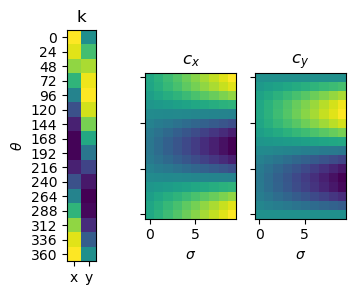

In [365]:
# setup initial conditions and parameters
import variables

k = l2(variables.k)
u = variables.u

nθ = 16
nσ = 10
θ = np.linspace(0, 2 * np.pi, nθ)
σ = np.linspace(0.1, 0.5, nσ)
d = np.ones([nθ, nσ])

k = np.stack([k * np.cos(θ), k * np.sin(θ)], axis=-1)
cg = group_velocity(k, d, σ, u)
cx, cy = spatial_velocity(cg, u)

θlabels = ["{:.0f}".format(180 * x / np.pi) for x in θ]
fig, axs = plt.subplots(1, 3, figsize=(4, 3))
axs[0].imshow(k)
axs[0].set_title('k')
axs[0].set_xticks([0,1], labels=['x', 'y'])
axs[0].set_ylabel(r'$\theta$')
axs[0].set_yticks(range(nθ), labels=θlabels)

axs[1].imshow(cx),axs[1].set_title(r'$c_x$'),axs[1].set_xlabel(r'$\sigma$')
axs[2].imshow(cy),axs[2].set_title(r'$c_y$'),axs[2].set_xlabel(r'$\sigma$')

for ax in axs:
    ax.label_outer()

In [366]:
# extract sweep indices
sweep1 = np.intersect1d(np.where(cx >= 0)[0], np.where(cy >= 0)[0])
sweep2 = np.intersect1d(np.where(cx < 0)[0], np.where(cy >= 0)[0])
sweep3 = np.intersect1d(np.where(cx < 0)[0], np.where(cy < 0)[0])
sweep4 = np.intersect1d(np.where(cx >= 0)[0], np.where(cy < 0)[0])

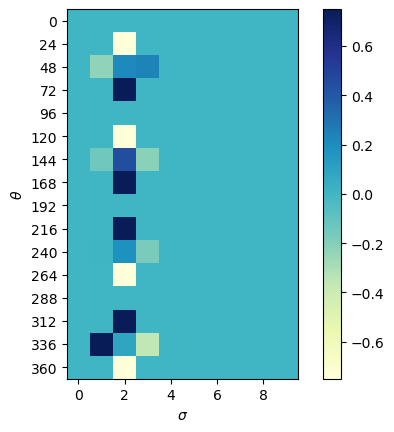

In [370]:
# change sign of cθ to refract clockwise(-)/counterclockwise(+)
cθ = -np.ones([nθ, nσ])
cσ = np.random.uniform(-1, 1, [nθ, nσ])

N = np.zeros([nθ, nσ])

ntheta = int(nθ / 4)
sweeps = [sweep1, sweep2, sweep3, sweep4]
flips = [lambda x: x, lambda x: np.flip(x, 1), lambda x: np.flip(x, 0), lambda x: np.flip(x, None)]

N1 = N.copy()
for sweep, flip in zip(sweeps, flips):
    Nj = N[sweep, :] # extract indices
    Nj[2, 2] = 1
    Nj = flip(Nj)   # rotate accordingly
    A = hybrid_matrix_theta(cθ[sweep, :], step=nσ) + hybrid_matrix_sigma(cσ[sweep, :], step=1)
    Nj = A @ Nj.ravel()
    N1[sweep, :] = flip(Nj.reshape([ntheta, nσ]))
    
fig, axs = plt.subplots(1, 1)
im = axs.imshow(N1, cmap='YlGnBu')
axs.set_xlabel(r'$\sigma$')
axs.set_ylabel(r'$\theta$')
axs.set_yticks(range(nθ), labels=θlabels)
plt.colorbar(im)